# **POINTNET WITH K-FOLD**

In [25]:
# necessary imports
import os
import numpy
import pandas
import random
import trimesh
import logging
import itertools
import tensorflow
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, regularizers, optimizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

# increase matplotlib plots font size
plt.rcParams.update({'font.size': 15})

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# directory where to save the best model for each fold
images_models_save_dir = 'saved_models/images'
pointclouds_models_save_dir = 'saved_models/pointclouds'

# needed to create pointclouds dataset
class_labels_dict = {'table':0, 'chair':1, 'lamp':2, 'dresser':3, 'sofa':4}

# utility function
def get_model_name(model_name, fold_counter):
    return model_name + '-fold-' + str(fold_counter) + '.h5'

# utility function to augment pointclouds data
def augment(points, label):
    # jitter points
    points += tensorflow.random.uniform(points.shape, -0.005, 0.005, dtype=tensorflow.float64)
    # shuffle points
    points = tensorflow.random.shuffle(points)
    return points, label

# plot loss and acuracy for each epoch
def plot_train_loss_accuracy(save_path, train_loss, train_accuracy, val_loss, val_accuracy):
    #print('Training Set Loss: ', train_loss)
    #print('Validation Set Loss: ', val_loss)
    plt.figure(figsize=(10, 10))
    plt.plot(train_loss,'o-g', label="Training Set")
    plt.plot(val_loss,'o-r', label="Validation Set")
    plt.title('Training and Validation Sets Loss')
    plt.legend(loc="upper right")
    plt.savefig(save_path + '-train-val-loss.jpg', dpi=200)
    plt.show()
    #print('Training Set Accuracy: ', train_accuracy)
    #print('Validation Set Accuracy: ', val_accuracy)
    plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy,'o-g', label="Training Set")
    plt.plot(val_accuracy,'o-r', label="Validation Set")
    plt.title('Training and Validation Sets Accuracy')
    plt.legend(loc="lower right")
    plt.savefig(save_path + '-train-val-accuracy.jpg', dpi=200)
    plt.show()

def plot_confusion_matrix(cm, classes, save_path, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        cm = numpy.around(cm, decimals=2)
        cm[numpy.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_path + '-confusion-matrix.jpg', bbox_inches='tight', dpi=200)
    plt.show()

In [26]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [27]:
# load images csv file
images_data = pandas.read_csv(os.path.join(DATASET_PATH, 'images.csv'))

# extract images path and class labels
images_X = images_data[['filename']]
images_Y = images_data[['class_label']]

# load pointclouds csv file
pointclouds_data = pandas.read_csv(os.path.join(DATASET_PATH, 'pointclouds.csv'))

# extract images path and class labels
pointclouds_X = pointclouds_data[['filename']]
pointclouds_Y = pointclouds_data[['class_label']]

## **Stratified K-Fold Cross Validation for pointclouds**

In [28]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [29]:
class OrthogonalRegularizer(tensorflow.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tensorflow.eye(num_features)

    def __call__(self, x):
        x = tensorflow.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tensorflow.tensordot(x, x, axes=(2, 2))
        xxt = tensorflow.reshape(xxt, (-1, self.num_features, self.num_features))
        return tensorflow.reduce_sum(self.l2reg * tensorflow.square(xxt - self.eye))


In [30]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tensorflow.keras.initializers.Constant(numpy.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [31]:
def pointclouds_kfold_validation(model_name, n_splits, test_size, shuffle, layers, learning_rate, decay, target_size, epochs, batch_size, resample_data=0):
    global pointclouds_data
    global pointclouds_X
    global pointclouds_Y
    if resample_data > 0:
        pointclouds_data = pointclouds_data.groupby('class_label', group_keys=False).apply(lambda x: x.sample(min(len(x), resample_data)))
        pointclouds_X = pointclouds_data[['filename']]
        pointclouds_Y = pointclouds_data[['class_label']]

    # fold counter
    fold_counter = 1
    
    # arrays to store test set loss and accuracy scores for each fold
    TEST_LOSS = []
    TEST_ACCURACY = []
    
    # split train and test dataset
    pointclouds_train, pointclouds_test = train_test_split(pointclouds_data, test_size=test_size, stratify=pointclouds_Y)
    pointclouds_train_X = pointclouds_train[['filename']]
    pointclouds_train_Y = pointclouds_train[['class_label']]

    # define stratified k fold cross validation parameters
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)

    # test data arrays
    test_pointclouds = []
    test_labels = []
    test_string_labels = {}

    # test split ready
    for index, test_data_row in pointclouds_test.iterrows():
        test_pointclouds.append(trimesh.load(test_data_row['filename'], force='mesh').sample(target_size))
        test_labels.append(class_labels_dict[test_data_row['class_label']])
        test_string_labels[index] = test_data_row['class_label']
    
    # convert to numpy array
    test_pointclouds = numpy.array(test_pointclouds)
    test_labels = numpy.array(test_labels)
    
    # debugging
    #print(len(test_pointclouds))
    #print(len(test_labels))
    #print(test_pointclouds)
    #print(test_labels)

    # create test tf.data.Dataset
    test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_pointclouds, test_labels))
    test_dataset = test_dataset.shuffle(len(test_pointclouds)).batch(batch_size)
    print("Found " + str(len(pointclouds_test)) + " validated pointcloud filenames belonging to " + str(len(pointclouds_test['class_label'].unique())) + " classes.")


    # generate train and validation folds
    for train_index, validation_index in stratified_kfold.split(pointclouds_train_X, pointclouds_train_Y):
        print("\n-------- STARTING FOLD: " + str(fold_counter) + " --------")

        # best model save path
        if not os.path.isdir(os.path.join(pointclouds_models_save_dir, model_name)):
            os.mkdir(os.path.join(pointclouds_models_save_dir, model_name))
        pointclouds_model_save_path = os.path.join(pointclouds_models_save_dir, model_name, get_model_name(model_name, fold_counter))

        # train and validation data arrays
        train_pointclouds = []
        train_labels = []
        train_string_labels = {}
        validation_pointclouds = []
        validation_labels = []
        validation_string_labels = {}

        # training and test folds indices
        training_data = pointclouds_train.iloc[train_index]
        validation_data = pointclouds_train.iloc[validation_index]

        for index, training_data_row in training_data.iterrows():
            train_pointclouds.append(trimesh.load(training_data_row['filename'], force='mesh').sample(target_size))
            train_labels.append(class_labels_dict[training_data_row['class_label']])
            train_string_labels[index] = training_data_row['class_label']

        # convert to numpy array
        train_pointclouds = numpy.array(train_pointclouds)
        train_labels = numpy.array(train_labels)
    
        # debugging
        #print(len(train_pointclouds))
        #print(len(train_labels))
        #print(train_pointclouds)
        #print(train_labels)

        # create train tf.data.Dataset
        train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_pointclouds, train_labels))
        train_dataset = train_dataset.shuffle(len(train_pointclouds)).map(augment).batch(batch_size)
        print("Found " + str(len(training_data)) + " validated pointcloud filenames belonging to " + str(len(training_data['class_label'].unique())) + " classes.")

        for index, validation_data_row in validation_data.iterrows():
            validation_pointclouds.append(trimesh.load(validation_data_row['filename'], force='mesh').sample(target_size))
            validation_labels.append(class_labels_dict[validation_data_row['class_label']])
            validation_string_labels[index] = validation_data_row['class_label']

        # convert to numpy array
        validation_pointclouds = numpy.array(validation_pointclouds)
        validation_labels = numpy.array(validation_labels)
    
        # debugging
        #print(len(validation_pointclouds))
        #print(len(validation_labels))
        #print(validation_pointclouds)
        #print(validation_labels)

        # create train tf.data.Dataset
        validation_dataset = tensorflow.data.Dataset.from_tensor_slices((validation_pointclouds, validation_labels))
        validation_dataset = validation_dataset.shuffle(len(validation_pointclouds)).map(augment).batch(batch_size)
        print("Found " + str(len(validation_data)) + " validated pointcloud filenames belonging to " + str(len(validation_data['class_label'].unique())) + " classes.")

        # create best model checkpoint
        best_model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(pointclouds_model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [best_model_checkpoint]

        # define model to be trained and tested
        inputs = tensorflow.keras.Input(shape=(target_size, 3))

        x = tnet(inputs, 3)
        x = conv_bn(x, 32)
        x = conv_bn(x, 32)
        x = tnet(x, 32)
        x = conv_bn(x, 32)
        x = conv_bn(x, 64)
        x = conv_bn(x, 512)
        x = layers.GlobalMaxPooling1D()(x)
        x = dense_bn(x, 256)
        x = layers.Dropout(0.3)(x)
        x = dense_bn(x, 128)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(target_size, activation="softmax")(x)

        model = tensorflow.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
        model.summary()

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=decay),
            metrics=["sparse_categorical_accuracy"],
        )

        history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

        # plot loss and acuracy for each training/validation fold
        plot_train_loss_accuracy(pointclouds_model_save_path, history.history["loss"], history.history["sparse_categorical_accuracy"],
                                 history.history["val_loss"], history.history["val_sparse_categorical_accuracy"])

        # LOAD BEST MODEL to evaluate the performance of the model on the test set
        #model.load_weights(pointclouds_model_save_path)

        # evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_dataset, batch_size=batch_size)
        print("Best model Test Loss: " + str(test_loss))
        print("Best model Test Accuracy: " + str(test_accuracy))
        
        # store test set loss and accuracy scores for each fold
        TEST_LOSS.append(test_loss)
        TEST_ACCURACY.append(test_accuracy)

        # Confution Matrix 
        Y_pred = model.predict(test_dataset)
        y_pred = numpy.argmax(Y_pred, axis=1)
        print('Confusion Matrix')
        cm = confusion_matrix(test_labels, y_pred)
        plot_confusion_matrix(cm, class_labels_dict.keys(), pointclouds_model_save_path, title='Confusion Matrix')

        # print Classification Report
        print('Classification Report')
        print(classification_report(test_labels, y_pred, target_names=class_labels_dict.keys()))

        # clean up before next fold
        del model
        tensorflow.keras.backend.clear_session()
        fold_counter += 1

#### **Developer harness test for Stratified K-Fold Cross Validation for pointclouds**

Found 394 validated pointcloud filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 2358 validated pointcloud filenames belonging to 5 classes.
Found 1179 validated pointcloud filenames belonging to 5 classes.
Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096, 32)    128         ['conv1d[0][0]']                 
 alization)                                             

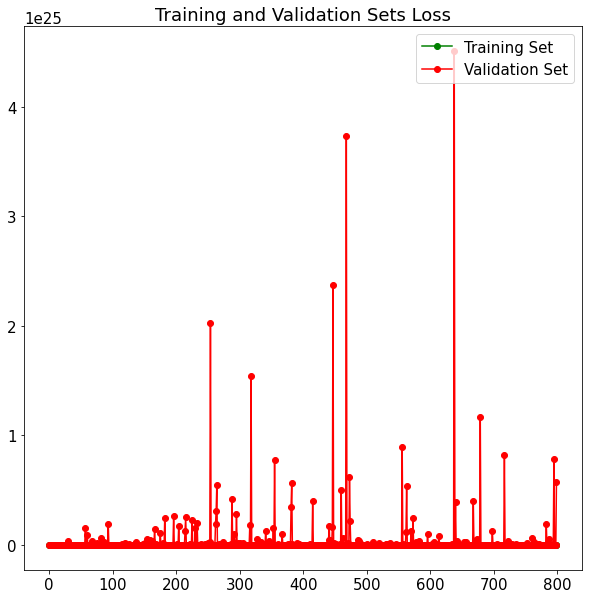

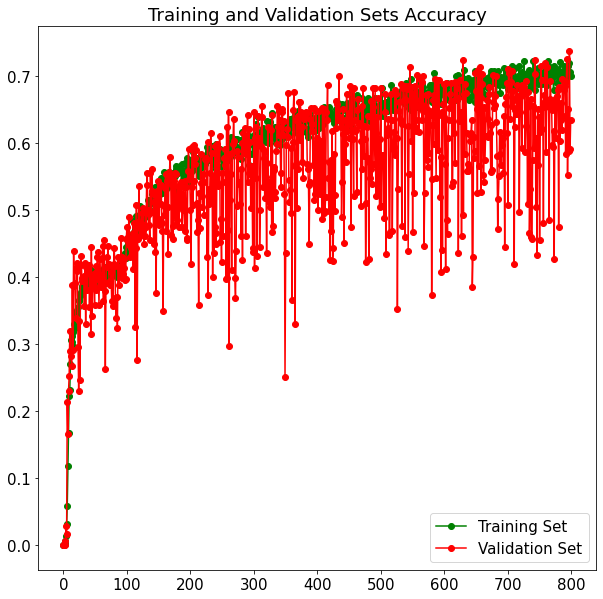

13/13 [==============================] - 0s 24ms/step - loss: 2489664401881734003476895105024.0000 - sparse_categorical_accuracy: 0.6497
Best model Test Loss: 2.489664401881734e+30
Best model Test Accuracy: 0.6497461795806885
Confusion Matrix
Normalized confusion matrix


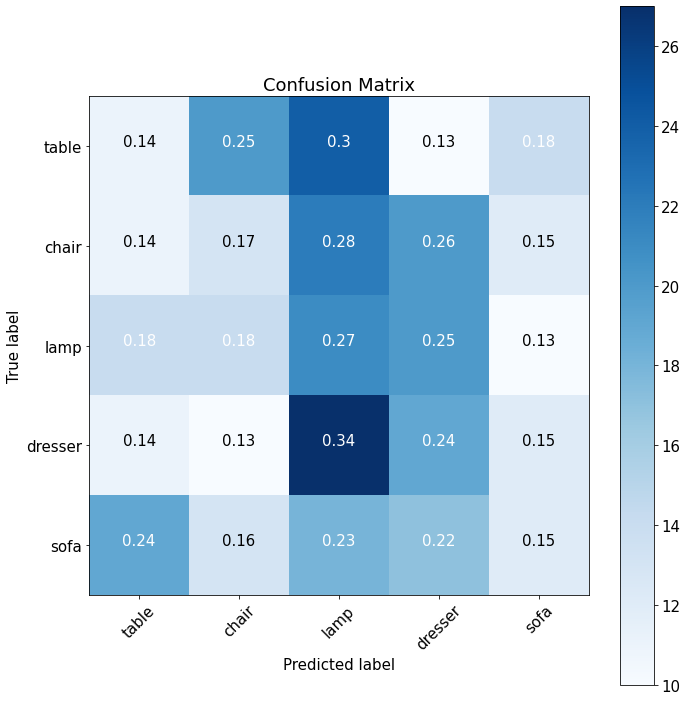

Classification Report
              precision    recall  f1-score   support

       table       0.17      0.14      0.15        79
       chair       0.19      0.17      0.18        78
        lamp       0.19      0.27      0.22        79
     dresser       0.22      0.24      0.23        79
        sofa       0.20      0.15      0.17        79

    accuracy                           0.19       394
   macro avg       0.19      0.19      0.19       394
weighted avg       0.19      0.19      0.19       394


-------- STARTING FOLD: 2 --------


KeyboardInterrupt: 

In [32]:
# clean up before next test
tensorflow.keras.backend.clear_session()

# train, validate and test
pointclouds_kfold_validation("testing-2", 3, 0.10, True, layers, 0.00001, 1e-6, 4096, 800, 32)